# Import library dan dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/new_dataset_cv.zip", 'r') as zip_ref:
  zip_ref.extractall("./")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Accuracy, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Model

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Image Data Generator



In [ ]:
# Tentukan default dimensi tinggi dan lebar gambar
img_width, img_height = 200, 200

# Jumlah epoch yang dilakukan untuk proses training
epochs = 15

# Ukuran batch yang digunakan
batch_size = 32

# Channel gambar yang digunakan 1 = grayscale, 3 = rgb
channel = 3

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

#proses load data train
train_generator = train_datagen.flow_from_directory('/content/new_dataset_cv/train',
                                              batch_size=batch_size,
                                              color_mode='rgb',
                                              target_size=(img_width,img_height),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

#proses load data validation
validation_generator = validation_datagen.flow_from_directory('/content/new_dataset_cv/validation',
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  target_size=(img_width,img_height),
                                                  class_mode='categorical',
                                                  shuffle=False)

#proses load data set
test_generator = test_datagen.flow_from_directory('/content/new_dataset_cv/test',
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  target_size=(img_width,img_height),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 5185 images belonging to 5 classes.
Found 575 images belonging to 5 classes.
Found 1440 images belonging to 5 classes.


In [ ]:
classes = list(train_generator.class_indices.keys())
classes

['brown', 'dark', 'light', 'medium', 'pale']

# Architecture Model MobileNet

In [ ]:
conv_base_mobilenet = MobileNet( include_top=False,
                                weights='imagenet',
                                input_shape=(img_width, img_height, channel)
                                )

for layer in conv_base_mobilenet.layers:
    layers.trainable = True

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
x = conv_base_mobilenet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(conv_base_mobilenet.input, predictions)

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[Recall(), Precision(),"accuracy"]
              )

# Summary of the Model Architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 100, 100, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 100, 100, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 100, 100, 32)     128       
 ation)                                                    

# Training Model CNN

In [ ]:
%time

history_skin = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=validation_generator)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Epoch 1/15
163/163 [==============================] - 64s 251ms/step - loss: 0.8146 - recall: 0.6253 - precision: 0.7360 - accuracy: 0.6864 - val_loss: 0.3515 - val_recall: 0.8330 - val_precision: 0.8600 - val_accuracy: 0.8504
Epoch 2/15
163/163 [==============================] - 40s 244ms/step - loss: 0.2816 - recall: 0.8831 - precision: 0.9107 - accuracy: 0.8980 - val_loss: 0.1855 - val_recall: 0.9217 - val_precision: 0.9364 - val_accuracy: 0.9287
Epoch 3/15
163/163 [==============================] - 40s 243ms/step - loss: 0.1470 - recall: 0.9462 - precision: 0.9584 - accuracy: 0.9516 - val_loss: 0.1351 - val_recall: 0.9513 - val_precision: 0.9546 - val_accuracy: 0.9513
Epoch 4/15
163/163 [==============================] - 40s 244ms/step - loss: 0.0907 - recall: 0.9689 - precision: 0.9750 - accuracy: 0.9722 - val_loss: 0.1267 - val_recall: 0.9548 - val_precision: 0.9632 - val_accuracy: 0.9548
Epoch 5/15
163/163 [=========

# Graph Loss and Accuracy

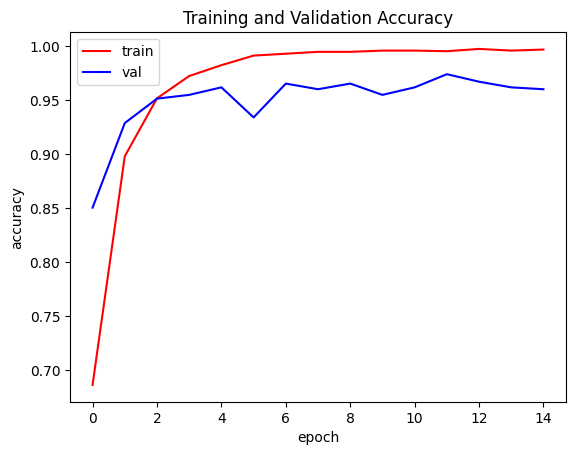

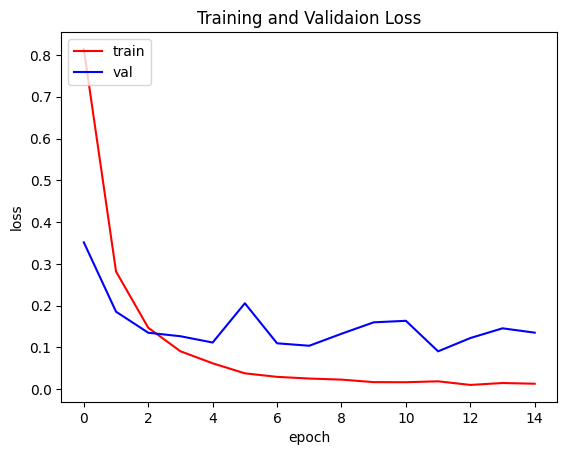

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

# Evaluation Model Using Testing Data

In [ ]:
# Prediction using testing data
preds = model.predict(test_generator,verbose=0)
test_labels = [np.argmax(pred) for pred in preds]

# Print Classification Report
print(classification_report(y_true=test_generator.classes,y_pred=test_labels,
                            target_names =['brown', 'dark', 'light', 'medium', 'pale'], digits=5))

              precision    recall  f1-score   support

       brown    0.93688   0.97917   0.95756       288
        dark    0.99640   0.96181   0.97880       288
       light    0.94040   0.98611   0.96271       288
      medium    0.98227   0.96181   0.97193       288
        pale    0.98556   0.94792   0.96637       288

    accuracy                        0.96736      1440
   macro avg    0.96830   0.96736   0.96747      1440
weighted avg    0.96830   0.96736   0.96747      1440



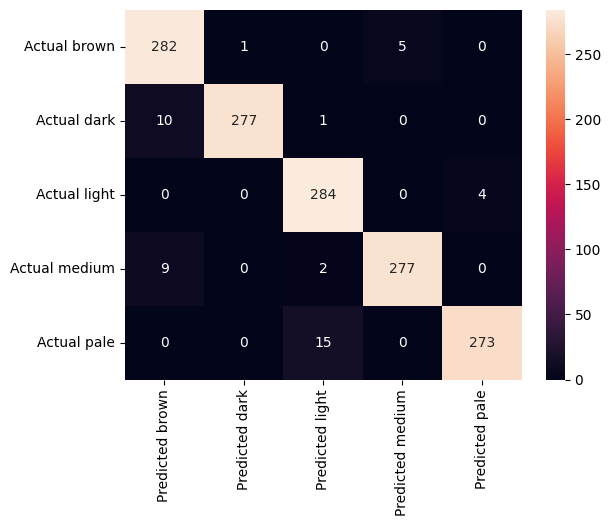

In [ ]:
# Prediction using testing data
preds = model.predict(test_generator,verbose=0)
test_labels = [np.argmax(pred) for pred in preds]

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, test_labels,
                                        labels=[0, 1, 2, 3, 4]),
                                        index=['Actual brown', 'Actual dark',
                                               'Actual light', 'Actual medium',
                                               'Actual pale'],
                                        columns=['Predicted brown', 'Predicted dark',
                                                 'Predicted light', 'Predicted medium',
                                                 'Predicted pale'
                                                ])
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

In [ ]:
# save model to h5 format
model.save('Model-Skin.h5')

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# Display result of prediction new data
model = tf.keras.models.load_model('Model-Skin.h5')

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])

  classes = list(train_generator.class_indices.keys())
  pred = model.predict(images, verbose=0)
  index = np.argmax(pred[0])
  probability= round(pred[0][index]*100, 2)

  plt.figure(figsize=(6,6))
  plt.axis('off')
  title = f'Predict : {probability}% {classes[index]}'
  plt.title(title)
  plt.imshow(np.squeeze(images))
  plt.show()